In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import * # module math
import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go

#import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

C:\Users\pavan\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning:

Blowfish has been deprecated



In [2]:
# getting data
customer_data= pd.read_csv('churn-bigml-80.csv')
customer_data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(customer_data.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [4]:
dataoveriew(customer_data, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 3333

Number of features: 20

Features:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

Missing values: 0

Unique values:
State                       51
Account length             212
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       46
Total day minutes         1667
Total day calls            119
Total day charge          1667
Total eve minutes         1611
Total eve calls            123
Total eve charge          1440
Total night minutes       1591
Total night calls          120
Total night charge         933
Total intl minutes         16

## Data Cleaning


In [5]:
round(100*(customer_data.isnull().sum()/customer_data.shape[0]))

State                     0.0
Account length            0.0
Area code                 0.0
International plan        0.0
Voice mail plan           0.0
Number vmail messages     0.0
Total day minutes         0.0
Total day calls           0.0
Total day charge          0.0
Total eve minutes         0.0
Total eve calls           0.0
Total eve charge          0.0
Total night minutes       0.0
Total night calls         0.0
Total night charge        0.0
Total intl minutes        0.0
Total intl calls          0.0
Total intl charge         0.0
Customer service calls    0.0
Churn                     0.0
dtype: float64

In [6]:
customer_data['Churn'].value_counts()

False    2850
True      483
Name: Churn, dtype: int64

ValueError: 'label' must be of length 'x'

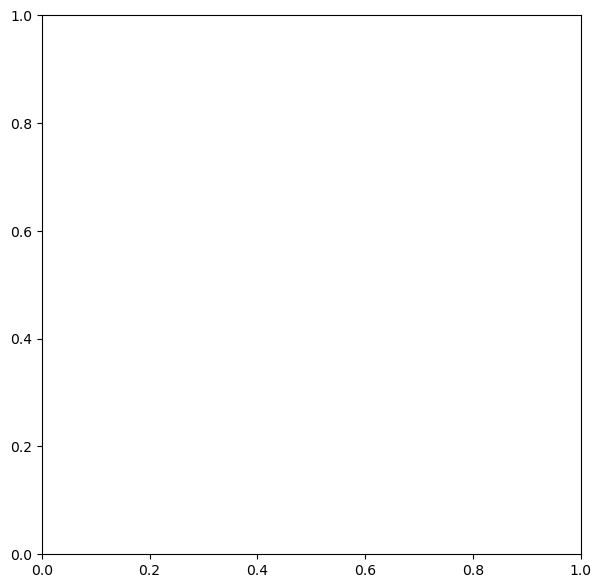

In [7]:
count = customer_data['Churn'].value_counts()

# Sort classes by label
sorted_classes = sorted(count.index)

plt.figure(figsize=(8, 7))
plt.pie(count[sorted_classes], labels=sorted_classes, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Churn/ No Churn')
plt.show()

In [8]:
#correlation
correlation = customer_data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


In [143]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Removing correlated and unneccessary columns
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge',
               'Total night charge', 'Total intl charge']

customer_data = customer_data.drop(columns = col_to_drop, axis = 1)

#target column
target_col = ["Churn"]

#number of levels in feature to be a categorical feature
nlevels = 6

#Separating categorical and numerical columns
#categorical columns
cat_cols = list(set(customer_data.nunique()[customer_data.nunique()<nlevels].keys().tolist()
                    + customer_data.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in customer_data.columns if x not in cat_cols + target_col]
print(num_cols)
#Binary columns with 2 values
bin_cols = customer_data.nunique()[customer_data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    customer_data[i] = le.fit_transform(customer_data[i])





['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls', 'Customer service calls']


In [144]:
scaling_columns=['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 'Total intl minutes', 'Total intl calls', 'Customer service calls']


In [145]:
#putting features variables in X
X = customer_data.drop(['Churn'], axis=1)

#putting response variables in Y
y = customer_data['Churn']
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)

#Scalaing columns for better performance of models
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[scaling_columns] = scaler.fit_transform(X_train[scaling_columns])
X_test[scaling_columns] = scaler.transform(X_test[scaling_columns])


In [146]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
random_oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_rand_samp, y_rand_samp = random_oversample.fit_resample(X_train, y_train)

In [147]:
from collections import Counter
# Before sampling class distribution
print(f'Before sampling class distribution:- {Counter(y_train)}')
# new class distribution
print(f'New class distribution:- {Counter(y_rand_samp)}')

Before sampling class distribution:- Counter({0: 1993, 1: 340})
New class distribution:- Counter({0: 1993, 1: 1993})


**Logistic Regression**

In [148]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
# Instantiating the model with best C
log_reg_model = LogisticRegression(C=100)

# Fitting the model on train dataset
log_reg_model.fit(X_rand_samp, y_rand_samp)

LogisticRegression(C=100)

In [149]:
y_train_pred = log_reg_model.predict(X_rand_samp)

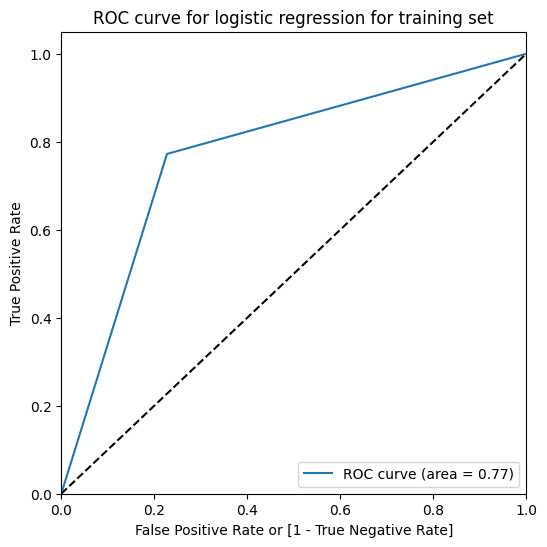

In [150]:
fpr, tpr, thresholds = metrics.roc_curve( y_rand_samp, y_train_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_rand_samp,y_train_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for logistic regression for training set')
plt.legend(loc="lower right")
plt.show()

In [151]:
print("Confusion Matrix for training set:")
print(confusion_matrix(y_rand_samp, y_train_pred))
print(f"Logistic Regression F1 Score for training set: {round(f1_score(y_rand_samp, y_train_pred)*100,2)}%")
print(f"Logistic Regression Classification Report for training set: \n {classification_report(y_rand_samp, y_train_pred)}")

Confusion Matrix for training set:
[[1540  453]
 [ 454 1539]]
Logistic Regression F1 Score for training set: 77.24%
Logistic Regression Classification Report for training set: 
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1993
           1       0.77      0.77      0.77      1993

    accuracy                           0.77      3986
   macro avg       0.77      0.77      0.77      3986
weighted avg       0.77      0.77      0.77      3986



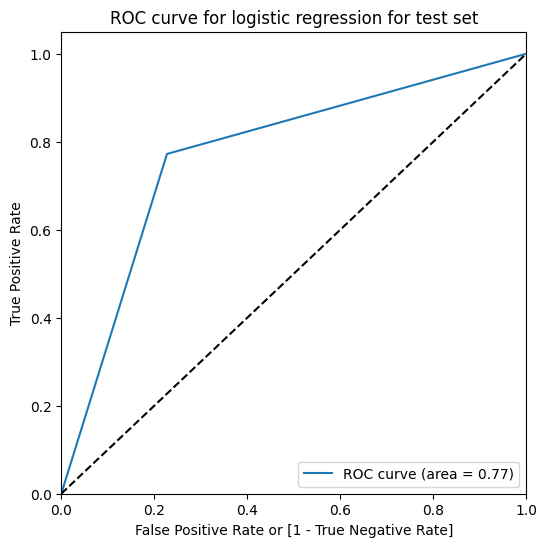

In [152]:
# Evaluating model on test set
y_test_pred = log_reg_model.predict(X_test)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for logistic regression for test set')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix for test set:
[[676 181]
 [ 34 109]]


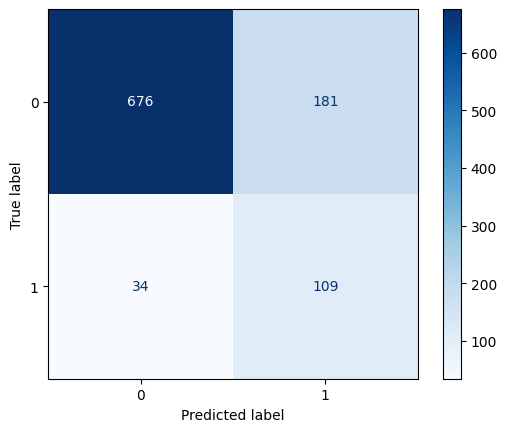

Logistic Regression F1 Score for test set: 50.35%
Logistic Regression Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.95      0.79      0.86       857
           1       0.38      0.76      0.50       143

    accuracy                           0.79      1000
   macro avg       0.66      0.78      0.68      1000
weighted avg       0.87      0.79      0.81      1000



In [153]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,recall_score, precision_score,ConfusionMatrixDisplay
print("Confusion Matrix for test set:")
lr_confusion = confusion_matrix(y_test, y_test_pred)
print(lr_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=lr_confusion, display_labels=log_reg_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("lr_confusion_matrix.png")
plt.show()
print(f"Logistic Regression F1 Score for test set: {round(f1_score(y_test, y_test_pred)*100,2)}%")
print(f"Logistic Regression Classification Report for test set: \n {classification_report(y_test, y_test_pred)}")

In [154]:
print(f"Accuracy score for test set is {accuracy_score(y_test, y_test_pred)}")

Accuracy score for test set is 0.785


Decision Tree

Confusion Matrix for training set:
[[1871  122]
 [ 376 1617]]
Decision Tree F1 Score for training set: 86.66%
Decision Tree Classification Report for training set: 
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      1993
           1       0.93      0.81      0.87      1993

    accuracy                           0.88      3986
   macro avg       0.88      0.88      0.87      3986
weighted avg       0.88      0.88      0.87      3986



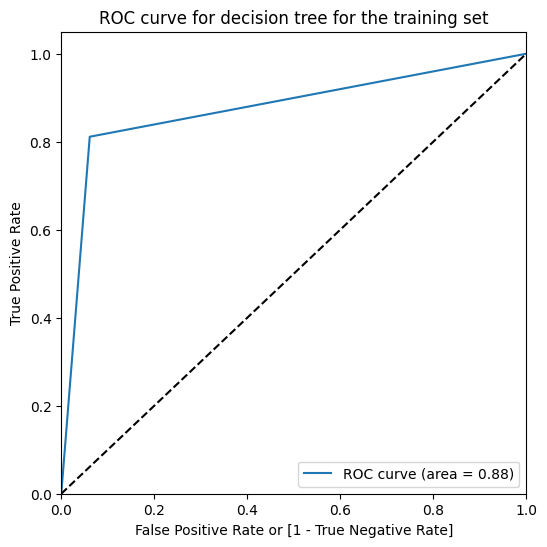

In [155]:
from sklearn.tree import DecisionTreeClassifier as DT

# Building Decision with optimal hypermaters
dt_model = DecisionTreeClassifier(criterion = "entropy",
                                  random_state = 100,
                                  max_depth=5,
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_model.fit(X_rand_samp, y_rand_samp)
y_train_pred = dt_model.predict(X_rand_samp)
print("Confusion Matrix for training set:")

dt_confusion = confusion_matrix(y_rand_samp, y_train_pred)
print(dt_confusion)
print(f"Decision Tree F1 Score for training set: {round(f1_score(y_rand_samp, y_train_pred)*100,2)}%")
print(f"Decision Tree Classification Report for training set: \n {classification_report(y_rand_samp, y_train_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_rand_samp, y_train_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_rand_samp,y_train_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for decision tree for the training set')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix for test set:
[[820  37]
 [ 37 106]]


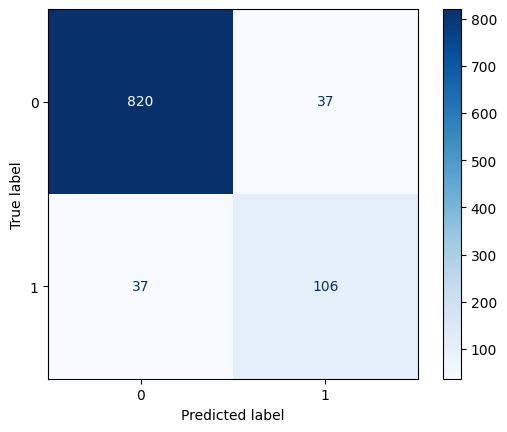

Decision Tree F1 Score for test set: 74.13%
Decision Tree Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       857
           1       0.74      0.74      0.74       143

    accuracy                           0.93      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.93      0.93      0.93      1000



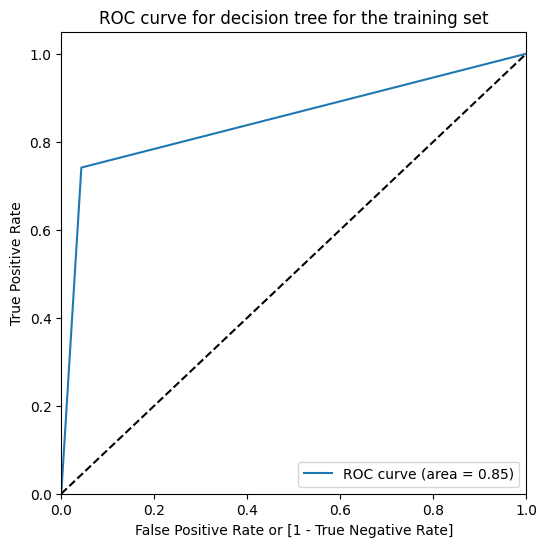

In [169]:
# Evaluating model on test set
y_test_pred = dt_model.predict(X_test)
print("Confusion Matrix for test set:")
dt_confusion = confusion_matrix(y_test, y_test_pred)
print(dt_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_confusion, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("dt_confusion_matrix.png")
plt.show()
print(f"Decision Tree F1 Score for test set: {round(f1_score(y_test, y_test_pred)*100,2)}%")
print(f"Decision Tree Classification Report for test set: \n {classification_report(y_test, y_test_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_test_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_test,y_test_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for decision tree for the test set')
plt.legend(loc="lower right")
plt.show()


K-Nearest Neighbors

Confusion Matrix for training set:
[[1747  246]
 [   3 1990]]
K-NN F1 Score for training set: 94.11%
K-NN  Classification Report for training set: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93      1993
           1       0.89      1.00      0.94      1993

    accuracy                           0.94      3986
   macro avg       0.94      0.94      0.94      3986
weighted avg       0.94      0.94      0.94      3986



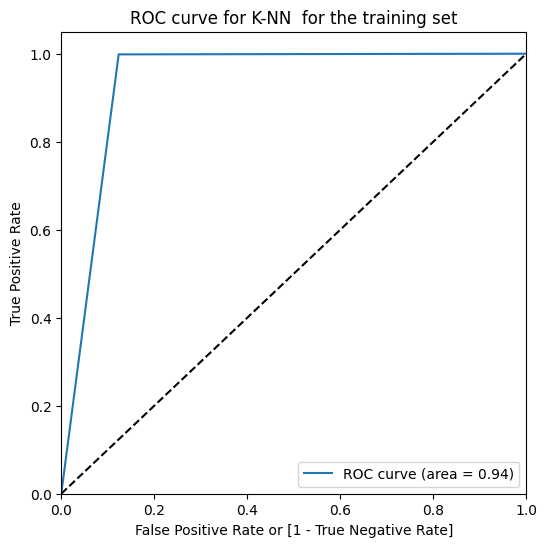

In [158]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                           weights='uniform')
knn.fit(X_rand_samp,y_rand_samp)
y_train_pred = knn.predict(X_rand_samp)
print("Confusion Matrix for training set:")
knn_confusion = confusion_matrix(y_rand_samp, y_train_pred)
print(knn_confusion)
print(f"K-NN F1 Score for training set: {round(f1_score(y_rand_samp, y_train_pred)*100,2)}%")
print(f"K-NN  Classification Report for training set: \n {classification_report(y_rand_samp, y_train_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_rand_samp, y_train_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_rand_samp,y_train_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for K-NN  for the training set')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix for test set:
[[737 120]
 [ 38 105]]


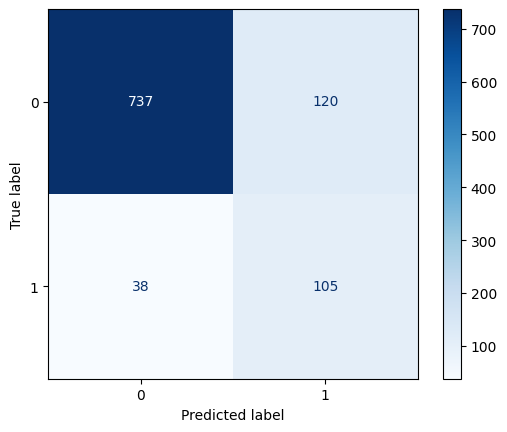

K-NN F1 Score for test set: 57.07%
K-NN Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       857
           1       0.47      0.73      0.57       143

    accuracy                           0.84      1000
   macro avg       0.71      0.80      0.74      1000
weighted avg       0.88      0.84      0.86      1000



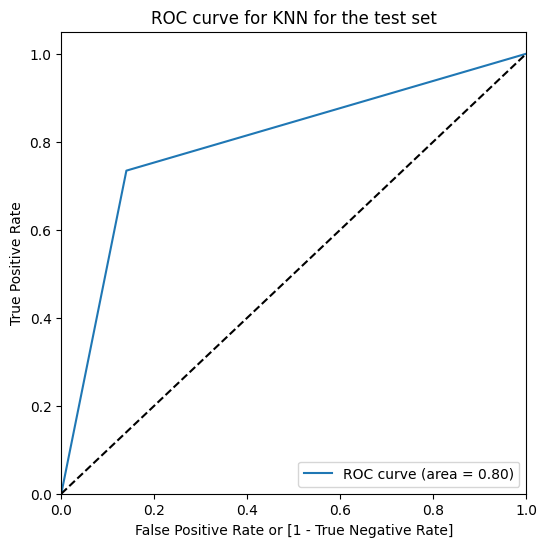

In [170]:
# Evaluating model on test set
y_test_pred = knn.predict(X_test)
print("Confusion Matrix for test set:")
knn_confusion = confusion_matrix(y_test, y_test_pred)
print(knn_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("knn_confusion_matrix.png")
plt.show()
print(f"K-NN F1 Score for test set: {round(f1_score(y_test, y_test_pred)*100,2)}%")
print(f"K-NN Classification Report for test set: \n {classification_report(y_test, y_test_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_test_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_test,y_test_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNN for the test set')
plt.legend(loc="lower right")
plt.show()

Naive Bayes

Confusion Matrix for test set:
[[1747  246]
 [   3 1990]]
Naive Bayes F1 Score for training set: 94.11%
Naive Bayes Classification Report for training set: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93      1993
           1       0.89      1.00      0.94      1993

    accuracy                           0.94      3986
   macro avg       0.94      0.94      0.94      3986
weighted avg       0.94      0.94      0.94      3986



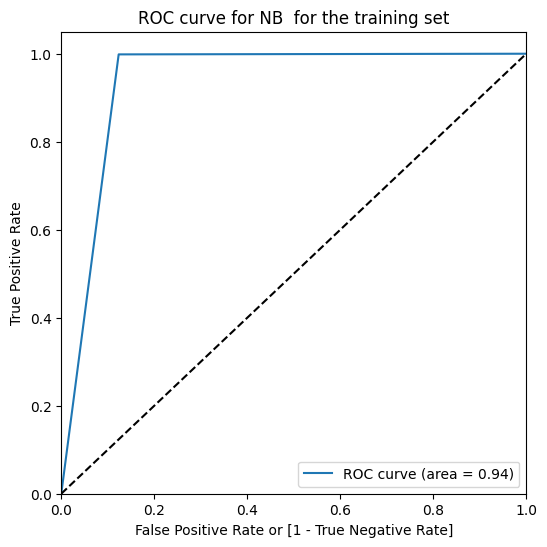

In [160]:
from sklearn.naive_bayes import GaussianNB as NB

nb = NB()
nb.fit(X_rand_samp,y_rand_samp)
y_train_pred = knn.predict(X_rand_samp)
print("Confusion Matrix for test set:")
nb_confusion = confusion_matrix(y_rand_samp, y_train_pred)
print(nb_confusion)
print(f"Naive Bayes F1 Score for training set: {round(f1_score(y_rand_samp, y_train_pred)*100,2)}%")
print(f"Naive Bayes Classification Report for training set: \n {classification_report(y_rand_samp, y_train_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_rand_samp, y_train_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_rand_samp,y_train_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for NB  for the training set')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix for test set:
[[737 120]
 [ 32 111]]


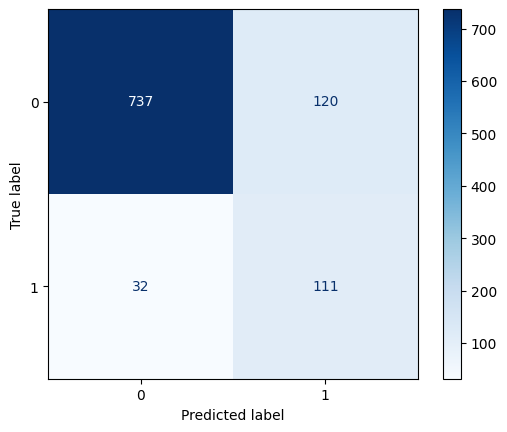

Naive Bayes F1 Score for test set: 59.36%
Naive Bayes Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       857
           1       0.48      0.78      0.59       143

    accuracy                           0.85      1000
   macro avg       0.72      0.82      0.75      1000
weighted avg       0.89      0.85      0.86      1000



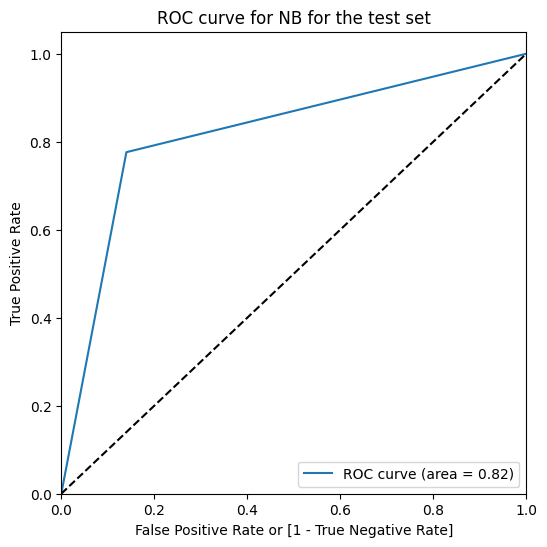

In [171]:
# Evaluating model on test set
y_test_pred = nb.predict(X_test)
print("Confusion Matrix for test set:")
nb_confusion = confusion_matrix(y_test, y_test_pred)
print(nb_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=nb_confusion, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("nb_confusion_matrix.png")
plt.show()
print(f"Naive Bayes F1 Score for test set: {round(f1_score(y_test, y_test_pred)*100,2)}%")
print(f"Naive Bayes Classification Report for test set: \n {classification_report(y_test, y_test_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_test_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_test,y_test_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for NB for the test set')
plt.legend(loc="lower right")
plt.show()

Linear Discriminant Analysis

Confusion Matrix for test set:
[[1545  448]
 [ 476 1517]]
LDA F1 Score for training set: 76.65%
LDA Classification Report for training set: 
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      1993
           1       0.77      0.76      0.77      1993

    accuracy                           0.77      3986
   macro avg       0.77      0.77      0.77      3986
weighted avg       0.77      0.77      0.77      3986



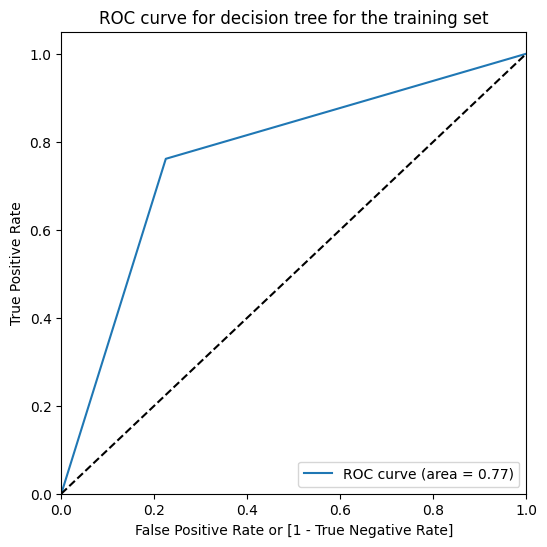

In [162]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the training data
lda.fit(X_rand_samp, y_rand_samp)
y_train_pred = lda.predict(X_rand_samp)
print("Confusion Matrix for test set:")
lda_confusion = confusion_matrix(y_rand_samp, y_train_pred)
print(lda_confusion)
print(f"LDA F1 Score for training set: {round(f1_score(y_rand_samp, y_train_pred)*100,2)}%")
print(f"LDA Classification Report for training set: \n {classification_report(y_rand_samp, y_train_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_rand_samp, y_train_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_rand_samp,y_train_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for LDA for the training set')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix for test set:
[[682 175]
 [ 35 108]]


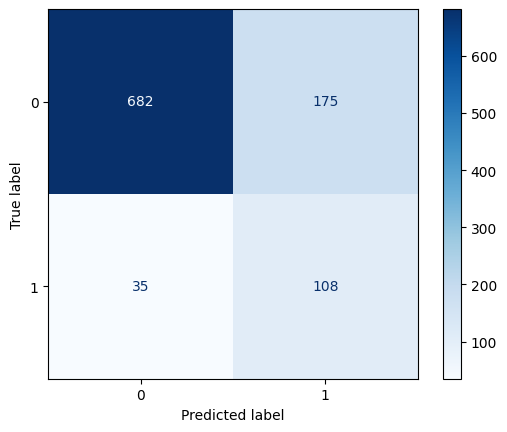

LDA  F1 Score for test set: 50.7%
LDA  Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       857
           1       0.38      0.76      0.51       143

    accuracy                           0.79      1000
   macro avg       0.67      0.78      0.69      1000
weighted avg       0.87      0.79      0.82      1000



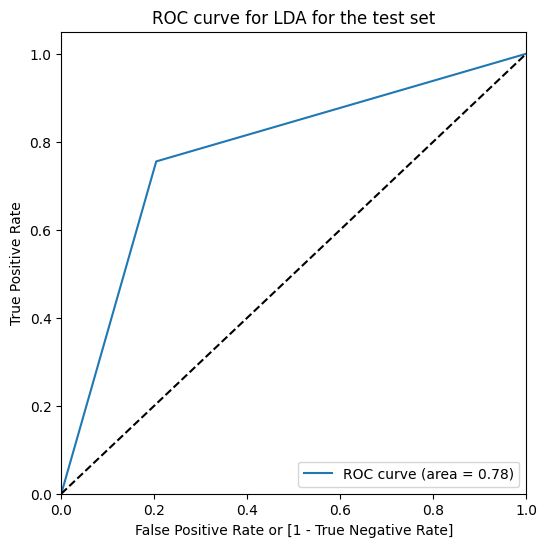

In [172]:
# Evaluating model on test set
y_test_pred = lda.predict(X_test)
print("Confusion Matrix for test set:")
lda_confusion = confusion_matrix(y_test, y_test_pred)
print(lda_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=lda_confusion, display_labels=dt_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("nb_confusion_matrix.png")
plt.show()
print(f"LDA  F1 Score for test set: {round(f1_score(y_test, y_test_pred)*100,2)}%")
print(f"LDA  Classification Report for test set: \n {classification_report(y_test, y_test_pred)}")
fpr, tpr, thresholds = metrics.roc_curve( y_test, y_test_pred,
                                              drop_intermediate = False )
roc_auc_score = metrics.roc_auc_score(y_test,y_test_pred)
plt.figure(figsize=(6, 6))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for LDA for the test set')
plt.legend(loc="lower right")
plt.show()

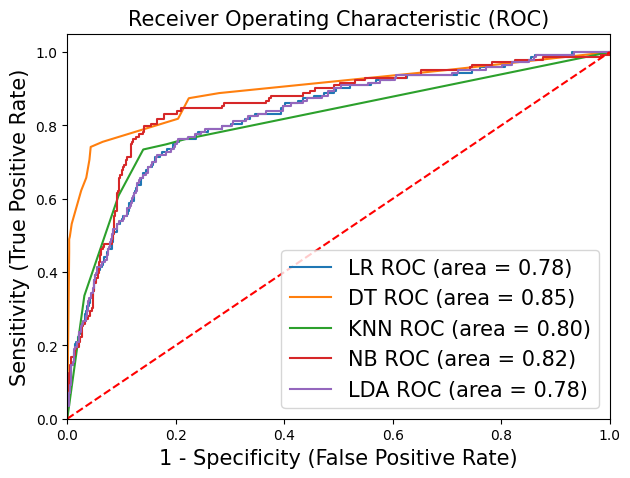

In [174]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
#ROC curve on test data
plt.figure(figsize=(7,5))
models = [
{
    'label': 'LR',
    'model': log_reg_model,
},
{
    'label': 'DT',
    'model': dt_model,
},

{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'NB',
    'model': nb,
},
{
    'label': 'LDA',
    'model': lda,
}

]

for m in models:
    model = m['model']
    model.fit(X_rand_samp, y_rand_samp)
    y_pred=model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=15)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=15)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
plt.legend(loc="lower right", fontsize=15)
plt.savefig("roc.jpeg", format='jpeg', dpi=300, bbox_inches='tight')
plt.show()